<a href="https://colab.research.google.com/github/pietoli/cnn_malaria_detection/blob/master/Malaria_basic_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wczytanie bibliotek

In [ ]:
import os
import glob
from collections import Counter
from concurrent import futures
import threading
import datetime

import cv2

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras import layers, models, optimizers
from keras.models import load_model

import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, classification_report, confusion_matrix


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# CONFIGS

In [ ]:
experiment_name = 'malaria_basic_cnn_50_epochs_with_dropout_adam_optimalizator'
#experiment_name = 'modelsmalaria_basic_cnn_30_epochs_without_dropout'
dataset_dir = "/content/drive/My Drive/Colab Notebooks/Malaria/dataset"
models_dir =  "/content/drive/My Drive/Colab Notebooks/Malaria/models"
weights_dir =  "/content/drive/My Drive/Colab Notebooks/Malaria/weights"
classification_reports_dir = "/content/drive/My Drive/Colab Notebooks/Malaria/reports"
plots_dir = "/content/drive/My Drive/Colab Notebooks/Malaria/plots"
confusion_dir = "/content/drive/My Drive/Colab Notebooks/Malaria/confusion matrix"

# Wczytanie danych

In [ ]:
# Ścieżki do folderów ze zdjęciami
infected_dir = os.path.join(dataset_dir,'Parasitized')
healthy_dir = os.path.join(dataset_dir,'Uninfected')

# Rozpakowanie plików
infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13779, 13779)

In [ ]:
np.random.seed(42)

# Utworzenie dataframe'u z plikami
files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['infected'] * len(infected_files) + ['uninfected'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True) #frac=1 oznacza, że zwrócone zostaną wszystkie wiersze w randomowej kolejności

files_df.head()

,filename,label
0,/content/drive/My Drive/Colab Notebooks/Malari...,infected
1,/content/drive/My Drive/Colab Notebooks/Malari...,infected
2,/content/drive/My Drive/Colab Notebooks/Malari...,uninfected
3,/content/drive/My Drive/Colab Notebooks/Malari...,uninfected
4,/content/drive/My Drive/Colab Notebooks/Malari...,uninfected


## Zapoznanie się z wielkością obrazów

In [ ]:
width = []
height = []
for f in files_df['filename']:
    shape = cv2.imread(f).shape
    width.append(shape[0])
    height.append(shape[1])
  
print("Średnia wielkość obrazków wynosi ({0},{1})".format(np.mean(width), np.mean(height)))    
print("Mediana wielkości obrazków wynosi ({0},{1})".format(np.median(width), np.median(height)))


KeyboardInterrupt: ignored

## Wyświetlenie przykładowych obrazów

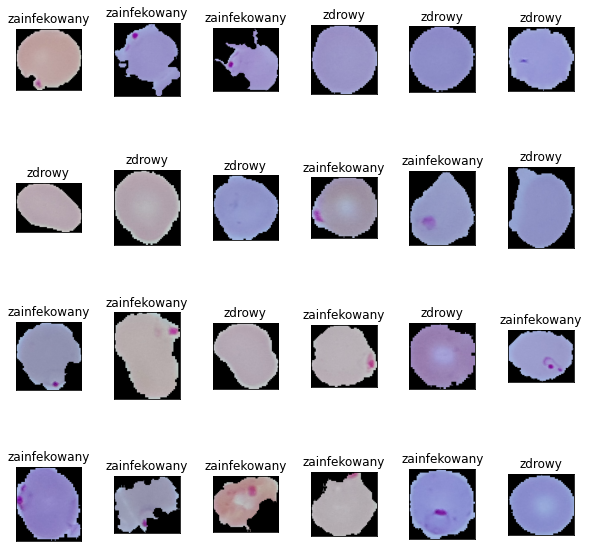

In [ ]:
rows = 4
columns = 6
fig = plt.figure(1, figsize=(10,10))


for i in range(1, rows*columns +1):
    r = np.random.randint(1, len(files_df['filename']))
    img = cv2.imread(files_df['filename'].iloc[r])
    fig.add_subplot(rows,columns,i)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(img/255.)
    plt.xticks([]) , plt.yticks([])
    plt.title(files_df['label'].iloc[r])
    #plt.savefig('/content/drive/My Drive/Colab Notebooks/Malaria/malaria_example.png', bbox_inches='tight')  
plt.show()




# Podział danych na zbiór treningowy, walidacyjny i testowy

Stosunek 60:20:20

In [ ]:

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=5512,
                                                                      random_state=42,
                                                                      stratify=files_df['label'].values)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=5512,
                                                                    random_state=42,
                                                                    stratify=train_labels)


print('Liczba danych treningowych: {0} w tym {1} zainfekowanych i {2} zdrowych.'.format(len(train_labels),Counter(train_labels)['infected'],Counter(train_labels)['uninfected']), 
      '\nLiczba danych walidacyjnych: {0} w tym {1} zainfekowanych i {2} zdrowych.'.format(len(val_labels),Counter(val_labels)['infected'],Counter(val_labels)['uninfected']), 
      '\nLiczba danych testowych: {0} w tym {1} zainfekowanych i {2} zdrowych.'.format(len(test_labels),Counter(test_labels)['infected'],Counter(test_labels)['uninfected']))

Liczba danych treningowych: 16534 w tym 8267 zainfekowanych i 8267 zdrowych. 
Liczba danych walidacyjnych: 5512 w tym 2756 zainfekowanych i 2756 zdrowych. 
Liczba danych testowych: 5512 w tym 2756 zainfekowanych i 2756 zdrowych.


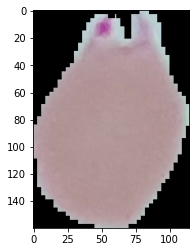

In [ ]:
img = cv2.imread(train_files[10])
plt.imshow(img)

# Przetworzenie danych

## Zmiana rozmiaru danych

In [ ]:
def process_train_files(width, height):
  train_data = []
  i = 0
  for f in train_files:
    print(i)
    image = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (width, height),interpolation=cv2.INTER_CUBIC)
    #image = np.array(image, dtype=np.float32)
    train_data.append(image)
    i += 1
  return np.array(train_data)

def process_test_files(width, height):
  test_data = []
  i = 0
  for f in test_files:
    image = cv2.imread(f, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (width, height),interpolation=cv2.INTER_CUBIC )
    #plt.imshow(image)
    #image = np.array(image, dtype=np.float32)
    test_data.append(image)
    i += 1
    print(i)
  return np.array(test_data)

def process_val_files(width, height):
  val_data = []
  i = 0
  for f in val_files:
    image = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (width, height),interpolation=cv2.INTER_CUBIC)
    #image = np.array(image, dtype=np.float32)
    val_data.append(image)
    i += 1
  return np.array(val_data)


In [ ]:

train_data = process_train_files(150, 150)
val_data = process_val_files(150,150)

In [ ]:
test_data = process_test_files(150,150)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


## Przeskalowanie danych

In [ ]:
# Przeskalowanie zbioru treningowego i walidacyjnego tak, aby wartości były w zakresie [0,1]
train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

NameError: ignored

## Encoding etykiet

In [ ]:
# Encoding etykiet
# Zainfekowany ma wartość 1, a zdrowy wartość 0
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['uninfected' 'infected' 'uninfected' 'infected' 'infected' 'uninfected'] [1 0 1 0 0 1]


# Zdefiniowanie hiperparametrów

In [ ]:
 # Params
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 10


# Architektura modelu customized

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

## Optymalizator

In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])
'''
# for this experiment i use Adam optimalizator
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=1e-6), loss='binary_crossentropy', metrics=['accuracy'])    '''         

"\n# for this experiment i use Adam optimalizator\nfrom keras.optimizers import Adam\nmodel.compile(optimizer=Adam(lr=1e-6), loss='binary_crossentropy', metrics=['accuracy'])    "

# Trenowanie modelu

In [ ]:
#early stopping
es = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=5)
#checkpoint
cp_filepath= experiment_name+"-weights-best.hdf5"
checkpoint = ModelCheckpoint(cp_filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
#csvlogger
log_filepath = experiment_name+'log.csv'
csvlogger = CSVLogger(log_filepath, append=False, separator=';')

callbacks_list = [checkpoint, es, csvlogger]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    verbose=1,
                    callbacks=callbacks_list)

Train on 16534 samples, validate on 5512 samples
Epoch 1/10
16534/16534 [==============================] - 16s 951us/step - loss: 0.5600 - accuracy: 0.6949 - val_loss: 0.2846 - val_accuracy: 0.8761

Epoch 00001: val_accuracy improved from -inf to 0.87609, saving model to malaria_basic_cnn_50_epochs_with_dropout_adam_optimalizator-weights-best.hdf5
Epoch 2/10
16534/16534 [==============================] - 15s 937us/step - loss: 0.2137 - accuracy: 0.9236 - val_loss: 0.1636 - val_accuracy: 0.9445

Epoch 00002: val_accuracy improved from 0.87609 to 0.94448, saving model to malaria_basic_cnn_50_epochs_with_dropout_adam_optimalizator-weights-best.hdf5
Epoch 3/10
16534/16534 [==============================] - 15s 927us/step - loss: 0.1741 - accuracy: 0.9451 - val_loss: 0.1573 - val_accuracy: 0.9445

Epoch 00003: val_accuracy did not improve from 0.94448
Epoch 4/10
16534/16534 [==============================] - 15s 922us/step - loss: 0.1595 - accuracy: 0.9476 - val_loss: 0.1535 - val_accuracy:

## Zapis modelu

In [ ]:
model.save(models_dir+ '/' + experiment_name +'.h5')
model.save_weights(weights_dir + '/' + experiment_name +'_weights.h5')

# Ocena jakości modelu na zbiorze testowym

In [ ]:
model = load_model(models_dir+ '/' + experiment_name +'.h5')

In [ ]:
# Przeskalowanie zbioru testowego
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((5512, 150, 150, 3), (5512,))

In [ ]:
basic_cnn_preds = model.predict(test_imgs_scaled)

In [ ]:
basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 for pred in basic_cnn_preds.ravel()])

In [ ]:
basic_cnn_pred_labels

array(['uninfected', 'infected', 'uninfected', ..., 'uninfected',
       'uninfected', 'uninfected'], dtype=object)

## Confusion matrix

In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=basic_cnn_pred_labels)

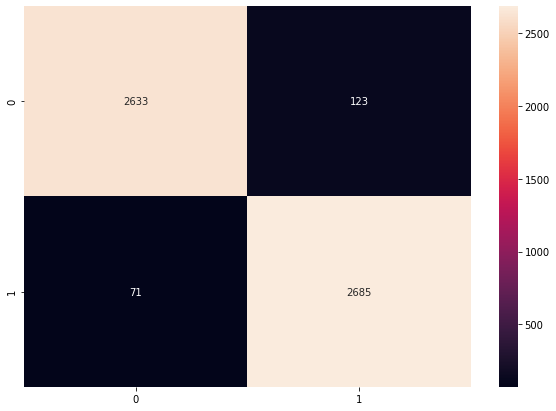

In [ ]:
plt.figure(figsize=(10,7))
heatmap = sn.heatmap(cm, annot=True, fmt="d")
plt.show(heatmap)

fig = heatmap.get_figure()
fig.savefig(confusion_dir+'/' + experiment_name + '.png')

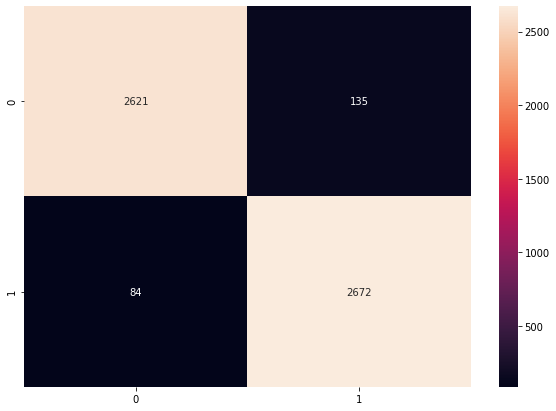

In [ ]:
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt="d")

In [ ]:

accuracy = accuracy_score(test_labels, basic_cnn_pred_labels)
precision = precision_score(test_labels, basic_cnn_pred_labels)
recall = recall_score(test_labels, basic_cnn_pred_labels, average='weighted')
f1 = f1_score(test_labels, basic_cnn_pred_labels, average='weighted')


In [ ]:
accuracy, precision, recall, 

(0.9648040638606676, 0.9649695923734384, 0.9648040638606676)

## Classification report

In [ ]:
report = classification_report(test_labels, basic_cnn_pred_labels, target_names=['infected', 'uninfected'], output_dict=True)


In [ ]:
df = pd.DataFrame(report).transpose()
report_name = classification_reports_dir + '/' +experiment_name + '.csv'
df.to_csv(report_name,sep='\t')
df

,precision,recall,f1-score,support
infected,0.973743,0.955370,0.964469,2756.000000
uninfected,0.956197,0.974238,0.965133,2756.000000
accuracy,0.964804,0.964804,0.964804,0.964804
macro avg,0.964970,0.964804,0.964801,5512.000000
weighted avg,0.964970,0.964804,0.964801,5512.000000


# Plots

In [ ]:
def make_accuracy_plot(history, plot_dir, experiment_name):
    """
    Funkcja zwraca wykres dokładności (accuracy) modelu na zbiorze treningowym
    i walidacyjnym.
    """
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 8))
    plt.plot(epochs, acc, label='Dokładność trenowania', marker='o')
    plt.plot(epochs, val_acc, label='Dokładność walidacji', marker='o')
    plt.legend()
    plt.title('Dokładność trenowania i walidacji')
    plt.xlabel('Epoki')
    plt.ylabel('Dokładność')
    save_path = plots_dir + '/' + experiment_name + '_accuracy_plot.png'
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

def make_loss_plot(history, plot_dir, experiment_name):
    """
    Funkcja zwraca wykres straty (loss) modelu na zbiorze treningowym
    i walidacyjnym.
    """
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(10, 8))
    plt.plot(epochs, loss, label='Strata trenowania', marker='o')
    plt.plot(epochs, val_loss, label='Strata walidacji', marker='o')
    plt.legend()
    plt.title('Strata trenowania i walidacji')
    plt.xlabel('Epoki')
    plt.ylabel('Strata')
    save_path = plots_dir + '/' + experiment_name + '_loss_plot.png'
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

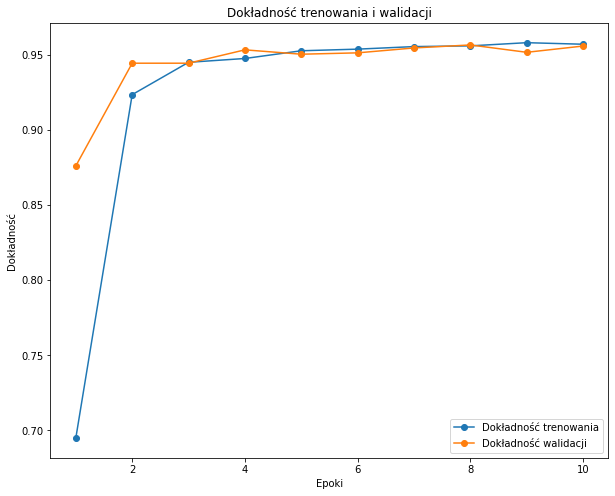

In [ ]:
make_accuracy_plot(history, plots_dir, experiment_name)

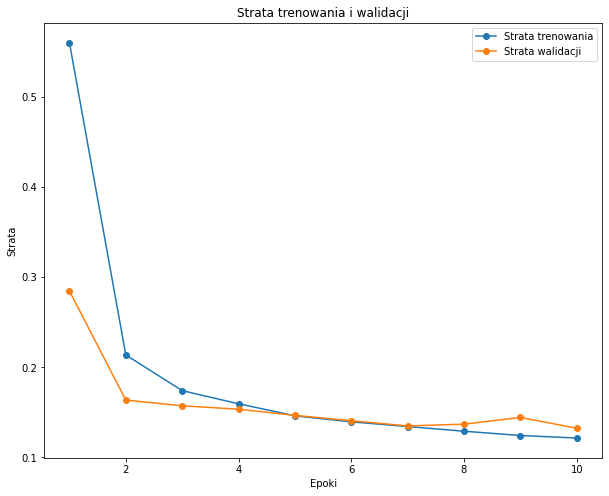

In [ ]:
make_loss_plot(history, plots_dir, experiment_name)